# Importing and Stuff

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the mapping of each letter

abc = 'abcdefghijklmnopqrstuvwxyz'
stoi = {s: i+1 for i, s in enumerate(abc)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [5]:
# build the databse

block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', ch)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

# Neural Net

## Spead out

In [7]:
C = torch.randn((27, 2))

In [8]:
emb = C[X]
emb

tensor([[[-0.5195,  0.1673],
         [-0.5195,  0.1673],
         [-0.5195,  0.1673]],

        [[-0.5195,  0.1673],
         [-0.5195,  0.1673],
         [-0.2469,  0.4752]],

        [[-0.5195,  0.1673],
         [-0.2469,  0.4752],
         [-0.7838,  1.3781]],

        ...,

        [[-0.2412, -0.3083],
         [-0.2412, -0.3083],
         [-0.4440, -1.1576]],

        [[-0.2412, -0.3083],
         [-0.4440, -1.1576],
         [-0.2412, -0.3083]],

        [[-0.4440, -1.1576],
         [-0.2412, -0.3083],
         [ 0.8056, -0.3616]]])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [10]:
# # M1
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# # M2
# torch.cat(torch.unbind(emb, 1), 1)
# # M3
# emb.view(32, 6)

In [11]:
h = (emb.view(-1, 6) @ W1 + b1).tanh()
h

tensor([[ 0.4312,  0.9145,  0.4637,  ...,  0.5946, -0.8736, -0.5119],
        [ 0.3292,  0.9169,  0.7672,  ...,  0.6641, -0.9749, -0.2996],
        [ 0.1695,  0.8487,  0.2974,  ...,  0.9249, -0.9993, -0.9782],
        ...,
        [ 0.8427,  0.9503,  0.4234,  ...,  0.4411,  0.9939,  0.7421],
        [ 0.6599,  0.9482,  0.8641,  ..., -0.3155,  0.4830,  0.8507],
        [ 0.7032,  0.8877,  0.9985,  ...,  0.9931,  0.1017,  0.9942]])

In [12]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2
logits

tensor([[ 13.4707,  -7.9412,  -2.0038,  ...,  -9.1632, -10.7694,   5.3604],
        [ 10.8908,  -8.4576,   2.0942,  ..., -13.0393,  -8.1259,   7.0538],
        [  8.4313, -13.1626,  -2.8339,  ..., -12.2665, -10.1414,   3.1870],
        ...,
        [ 14.7654,   3.3301,  -2.5421,  ...,   1.8531,   5.5115,  11.1362],
        [ 10.6788,   2.3801,  -5.4696,  ...,  -7.0930,   4.6089,  10.2256],
        [  3.8990,  10.3963,   3.6428,  ..., -15.7599,   4.9319,  13.8182]])

In [14]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [15]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)    # Same as the commented lines but more efficient
F.softmax(logits, dim=1)

tensor([[8.7834e-01, 4.4116e-10, 1.6719e-07,  ..., 1.2999e-10, 2.6081e-11,
         2.6389e-04],
        [4.8221e-01, 1.9069e-09, 7.2931e-05,  ..., 1.9521e-11, 2.6568e-09,
         1.0395e-02],
        [6.0489e-03, 2.5326e-12, 7.7486e-08,  ..., 6.2045e-12, 5.1955e-11,
         3.1922e-05],
        ...,
        [1.4961e-01, 1.6170e-06, 4.5542e-09,  ..., 3.6920e-07, 1.4324e-05,
         3.9704e-03],
        [4.9082e-01, 1.2213e-04, 4.7619e-08,  ..., 9.3920e-09, 1.1345e-03,
         3.1199e-01],
        [2.6634e-06, 1.7668e-03, 2.0616e-06,  ..., 7.7212e-15, 7.4824e-06,
         5.4113e-02]])

## Cleaned up

In [16]:
# build the databse
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training, dev and test split
# 80%   10%   10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [18]:
# All the parameters

# C = torch.ones((27, 10), requires_grad=True)
# W1 = torch.ones((30, 200), requires_grad=True)
# b1 = torch.ones(200, requires_grad=True)
# W2 = torch.ones((200, 27), requires_grad=True)
# b2 = torch.ones(27, requires_grad=True)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), requires_grad=True, generator=g)
W1 = torch.randn((30, 200), requires_grad=True, generator=g)
b1 = torch.randn(200, requires_grad=True, generator=g)
W2 = torch.randn((200, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]
print('We have', sum([p.nelement() for p in parameters]), 'number of parameters!')

We have 11897 number of parameters!


In [19]:
# Creating an array for Learning Rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
lrsi = []
lossi = []
stepi = []

In [21]:
# for lr in lrs:
for i in range(200_000):
    # Construct Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # Forward Pass
    emb = C[Xtr[ix]]
    h = (emb.view(-1, 30) @ W1 + b1).tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    stepi.append(i)
    # lrsi.append(lre[i])
    lossi.append(loss.log10().item())

# print(loss.item())

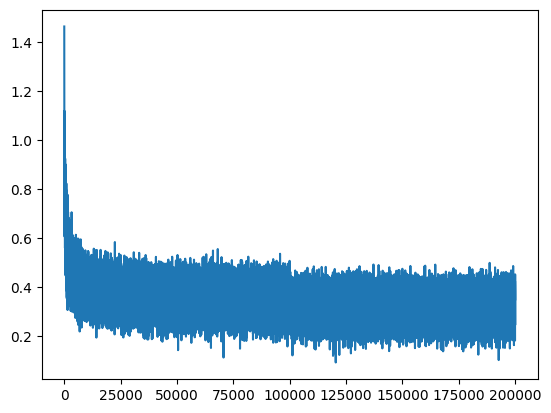

In [22]:
# use the graph to see good learning rates\
# plt.plot(lrsi, lossi)
plt.plot(stepi, lossi)


In [23]:
len(stepi)

200000

In [24]:
emb = C[Xtr]
h = (emb.view(-1, 30) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1120, grad_fn=<NllLossBackward0>)

In [25]:
emb = C[Xdev]
h = (emb.view(-1, 30) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1536, grad_fn=<NllLossBackward0>)

\# To visualize the C tensor when it was 2d\
plt.figure(figsize=(8, 8))\
plt.scatter(C\[:, 0].data, C\[:, 1].data, s=200)\
for i in range(C.shape\[0]):\
    plt.text(C\[i, 0].item(), C\[i, 1].item(), itos\[i], ha="center", va="center", color="white")\
plt.grid('minor')\

In [26]:
# Sampling from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


aymiah.
kyra.
cazaraina.
yyabellesten.
tahman.
safton.
kamarose.
jussa.
arthamar.
siil.
jasloy.
anshadeon.
kariai.
ggas.
malane.
avarthit.
choy.
zavistia.
xul.
kaylon.
